<a href="https://colab.research.google.com/github/ravichas/AMPL-Tutorial/blob/master/Delaney_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Predicting Solubility Using AMPL</h1>

The ATOM Modeling PipeLine (AMPL; https://github.com/ATOMconsortium/AMPL) is an open-source, modular, extensible software pipeline for building and sharing models to advance in silico drug discovery.

**Warning: This is an experimental notebook**

# Goal: Predict solubility using the ATOM Modeling Pipeline (AMPL) on the public dataset

In this notebook, we describe the following steps using AMPL:

1.   Read a public dataset containing chemical structures and some properties
1.   Curate the dataset 
2.   Fit a simple model
3.   Predict solubility for withheld compounds


## Set up
We first import the AMPL modules for use in this notebook.

The relevant AMPL modules for this example are listed below:

|module|Description|
|-|-|
|`atomsci.ddm.pipeline.model_pipeline`|The model pipeline module is used to fit models and load models for prediction.|
|`atomsci.ddm.pipeline.parameter_parser`|The parameter parser reads through pipeline options for the model pipeline.|
|`atomsci.ddm.utils.curate_data`|The curate data module is used for data loading and pre-processing.|
|`atomsci.ddm.utils.struct_utils`|The structure utilities module is used to process loaded structures.|
|`atomsci.ddm.pipeline.perf_plots`|Perf plots contains a variety of plotting functions.|

## Install AMPL

In [1]:
%tensorflow_version 1.x

# get the Anaconda file 
! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! chmod +x Anaconda3-2019.10-Linux-x86_64.sh
! bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local

! time conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc

# install mordred, bravado and molvs
! time conda install -c conda-forge -y mordred bravado molvs

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

TensorFlow 1.x selected.
--2021-03-10 20:11:20--  https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 530308481 (506M) [application/x-sh]
Saving to: ‘Anaconda3-2019.10-Linux-x86_64.sh’

Anaconda3-2019.10-L 100%[===================>] 505.74M   211MB/s    in 2.4s    

2021-03-10 20:11:23 (211 MB/s) - ‘Anaconda3-2019.10-Linux-x86_64.sh’ saved [530308481/530308481]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _ipyw_jlab_nb_ext_conf==0.1.0=py37_0
    - _libgcc_mutex==0.1=main
    - alabaster==0.7.12=py37_0
    - anaconda-client==1.7.2=py37_0
    - anaconda-navigator==1.9.7

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - bravado
    - molvs
    - mordred


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bravado-11.0.3             |     pyhd8ed1ab_0          31 KB  conda-forge
    bravado-core-5.17.0        |     pyh9f0ad1d_0          48 KB  conda-

In [2]:
# Load AMPL in this notebook
import sys

site_packages_path = '/content/AMPL/lib/python3.6/site-packages'
if site_packages_path not in sys.path:
  sys.path.insert(1, site_packages_path)
sys.path

['/tensorflow-1.15.2/python3.7',
 '/content/AMPL/lib/python3.6/site-packages',
 '',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/usr/local/lib/python3.7/site-packages/']

In [3]:
# There is a problem with the previously imported cffi, so delete it and 
# load it with AMPL instead
if 'cffi' in sys.modules:
  del sys.modules['cffi']

In [4]:
# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')

import json
import numpy as np
import pandas as pd
import os
import requests
import sys

import atomsci.ddm.pipeline.model_pipeline as mp
import atomsci.ddm.pipeline.parameter_parser as parse
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.utils.struct_utils as struct_utils
from atomsci.ddm.pipeline import perf_plots as pp


## Data curation

We then download and do very simple curation to the related dataset.

We need to set the directory we want to save files to. Next we download the dataset.

In [5]:
working_dir = '/content'

In [6]:
dataset_file = os.path.join(working_dir, 'delaney-processed.csv')
if (not os.path.isfile(dataset_file)):
    r = requests.get('https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/delaney-processed_curated_external.csv', verify=True)
    with open(dataset_file, 'wb') as f:
        f.write(r.content)

Next, we load the downloaded dataset, and process the compound structures:

In [7]:
# Load the Delaney dataset
raw_df = pd.read_csv(dataset_file)

# Generate SMILES, InChI keys for dataset with curation and structure modules.
# RDkit modules are used to process the SMILES strings
raw_df['rdkit_smiles'] = raw_df['smiles'].apply(curate_data.base_smiles_from_smiles)
raw_df['inchi_key'] = raw_df['smiles'].apply(struct_utils.smiles_to_inchi_key)

data = raw_df
data['compound_id'] = data['inchi_key']

## Let us review the dataset

In [8]:
raw_df

,Unnamed: 0,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,rdkit_smiles,inchi_key,compound_id,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate
0,0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...,XUCIJNAGGSZNQT-UHFFFAOYSA-N,XUCIJNAGGSZNQT-UHFFFAOYSA-N,-0.770,NaN,-0.0,0
1,1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2,Cc1occc1C(=O)Nc1ccccc1,JFSPBVWPKOEZCB-UHFFFAOYSA-N,JFSPBVWPKOEZCB-UHFFFAOYSA-N,-3.300,NaN,-0.0,0
2,2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O),CC(C)=CCCC(C)=CC=O,WTEVQBCEXWBHNA-UHFFFAOYSA-N,WTEVQBCEXWBHNA-UHFFFAOYSA-N,-2.060,NaN,-0.0,0
3,3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21,GBROPGWFBFCKAG-UHFFFAOYSA-N,GBROPGWFBFCKAG-UHFFFAOYSA-N,-7.870,NaN,-0.0,0
4,4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1,c1ccsc1,YTPLMLYBLZKORZ-UHFFFAOYSA-N,YTPLMLYBLZKORZ-UHFFFAOYSA-N,-1.330,NaN,-0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,112,Pentane,-2.261,1,72.151,0,0,2,0.00,-3.180,CCCCC,CCCCC,OFBQJSOFQDEBGM-UHFFFAOYSA-N,OFBQJSOFQDEBGM-UHFFFAOYSA-N,-3.180,NaN,-0.0,0
113,113,Phenol,-1.991,1,94.113,1,1,0,20.23,0.000,c1ccccc1O,Oc1ccccc1,ISWSIDIOOBJBQZ-UHFFFAOYSA-N,ISWSIDIOOBJBQZ-UHFFFAOYSA-N,0.000,NaN,NaN,0
114,114,2-aminoanthracene,-3.789,1,193.249,1,3,0,26.02,-5.170,Nc3ccc2cc1ccccc1cc2c3,Nc1ccc2cc3ccccc3cc2c1,YCSBALJAGZKWFF-UHFFFAOYSA-N,YCSBALJAGZKWFF-UHFFFAOYSA-N,-5.170,NaN,-0.0,0
115,115,theobromine,-1.050,1,180.167,1,2,0,72.68,-2.523,Cn1cnc2n(C)c(=O)[nH]c(=O)c12,Cn1cnc2c1c(=O)[nH]c(=O)n2C,YAPQBXQYLJRXSA-UHFFFAOYSA-N,YAPQBXQYLJRXSA-UHFFFAOYSA-N,-2.523,NaN,-0.0,0


## Let us view some molecules

In [9]:
raw_df['smiles'][0:10]

0    OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1                               Cc1occc1C(=O)Nc2ccccc2
2                                 CC(C)=CCCC(C)=CC(=O)
3                   c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4                                              c1ccsc1
5                                       c2ccc1scnc1c2 
6                   Clc1cc(Cl)c(c(Cl)c1)c2c(Cl)cccc2Cl
7                     CC12CCC3C(CCc4cc(O)ccc34)C2CCC1O
8       ClC4=C(Cl)C5(Cl)C3C1CC(C2OC12)C3C4(Cl)C5(Cl)Cl
9     COc5cc4OCC3Oc2c1CC(Oc1ccc2C(=O)C3c4cc5OC)C(C)=C 
Name: smiles, dtype: object

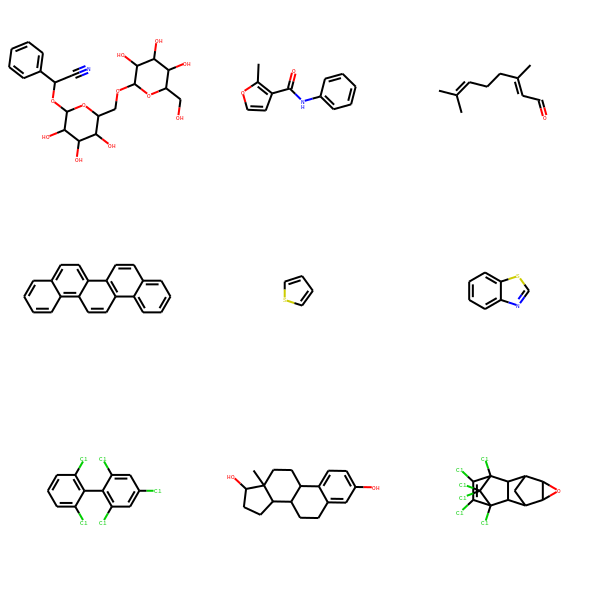

In [10]:
from rdkit import Chem
from rdkit.Chem import Draw
from itertools import islice

molecules = [Chem.MolFromSmiles(smiles) for smiles in islice(raw_df['smiles'], 9)]

Draw.MolsToGridImage(molecules)

The next step is to address the case where we have multiple measurements for a single structure (by RDkit canonical SMILEs string). We have a function in the `curate_data()` module to address process compounds. The function parameters are listed below along with an explanation of each parameter:

The dataset is a curated dataset. For demonstration, let us remove the curated columns after saving a backup copy. 

In [11]:
data_orig = data

In [12]:
del_features = ['VALUE_NUM_mean', 'VALUE_NUM_std', 'Perc_Var', 'Remove_BadDuplicate']
data.drop(labels=del_features, axis=1, inplace=True)

In [13]:
data.columns

Index(['Unnamed: 0', 'Compound ID',
       'ESOL predicted log solubility in mols per litre', 'Minimum Degree',
       'Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings',
       'Number of Rotatable Bonds', 'Polar Surface Area',
       'measured log solubility in mols per litre', 'smiles', 'rdkit_smiles',
       'inchi_key', 'compound_id'],
      dtype='object')

In [14]:
# column: Response values column
column = 'measured log solubility in mols per litre'

# tolerance: Percentage of individual respsonse values allowed to different from the average to be included in averaging
tolerance = 10

# list_bad_duplicates: Print structures with bad duplicates
list_bad_duplicates = 'Yes'

# max_std: Maximum allowed standard deviation for computed average response value
# NOTE: In this example, we set this value very high to disable this feature
max_std = 100000

# compound_id: Compound ID column
compound_id = 'compound_id'

# smiles_col: SMILES column
smiles_col = 'rdkit_smiles'

curated_df = curate_data.average_and_remove_duplicates(column, tolerance, 
                                                       list_bad_duplicates, 
                                                       data, max_std, 
                                                       compound_id=compound_id, 
                                                       smiles_col=smiles_col)
curated_file = os.path.join(working_dir, 'delaney_curated.csv')
curated_df.to_csv(curated_file, index=False)


featurizer = 'ecfp'
model_type = 'RF'
response_cols = ['VALUE_NUM_mean']

Bad duplicates removed from dataset
Dataframe size (117, 18)
List of 'bad' duplicates removed
Empty DataFrame
Columns: [compound_id, measured log solubility in mols per litre, VALUE_NUM_mean, Perc_Var, VALUE_NUM_std]
Index: []

Dataset de-duplicated
Dataframe size (117, 18)
New column created with averaged values:  VALUE_NUM_mean


Now that we have a curated dataset, we decide what type of featurizer and model we would like. See documentation for all available options. We also set the name of the new averaged response value column.

In [15]:
featurizer = 'ecfp'
model_type = 'RF'
response_cols = ['VALUE_NUM_mean']

Next we set up the parameters for our model. We set datastore and save_results to False to indicate that we are reading the input file and saving the results directly to the file system. There are a wide range of settable parameters; see the documentation for more details.

In [16]:
smiles_col

'rdkit_smiles'

In [17]:
params={"datastore": "False",
        "save_results": "False",
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_cols,
        "featurizer": featurizer,
        "model_type": model_type,
        "result_dir": working_dir,
        "dataset_key": curated_file}

We use parse.wrapper to process our input configuration. We then build the model pipeline, train the model, and plot the predicted versus true values for our train, valid, test sets.

2021-03-10 20:19:28,668 Dataset of length 117 is shorter than the required length 200
2021-03-10 20:19:28,669 Splitting data by scaffold
2021-03-10 20:19:28,792 Dataset split table saved to /content/delaney_curated_train_valid_test_scaffold_f4679868-41b0-4b10-bb66-239b1ff64ad8.csv


number of features: 1024
n_cnt [117.]
y_means [-3.30105128]
y_stds [2.17720636]
TIMING: dataset construction took 0.008 s
Loading dataset from disk.
TIMING: dataset construction took 0.004 s
Loading dataset from disk.
TIMING: dataset construction took 0.005 s
Loading dataset from disk.


2021-03-10 20:19:30,247 Wrote model metadata to file /content/delaney_curated/RF_ecfp_scaffold_regression/a7e4224f-8d40-49e7-b727-61d64dda7cc9/model_metadata.json
2021-03-10 20:19:30,290 Wrote model metrics to file /content/delaney_curated/RF_ecfp_scaffold_regression/a7e4224f-8d40-49e7-b727-61d64dda7cc9/model_metrics.json


Wrote model tarball to /content/delaney_curated_model_a7e4224f-8d40-49e7-b727-61d64dda7cc9.tar.gz


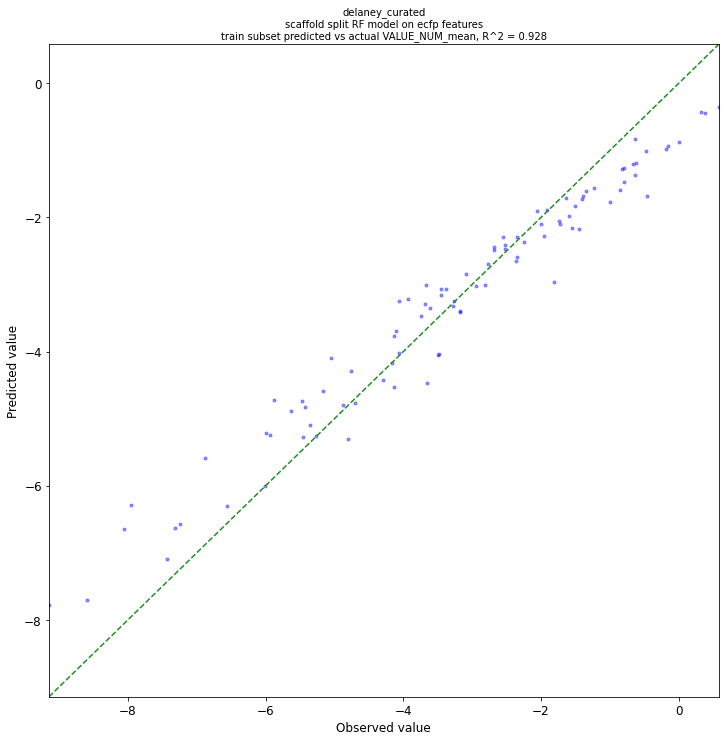

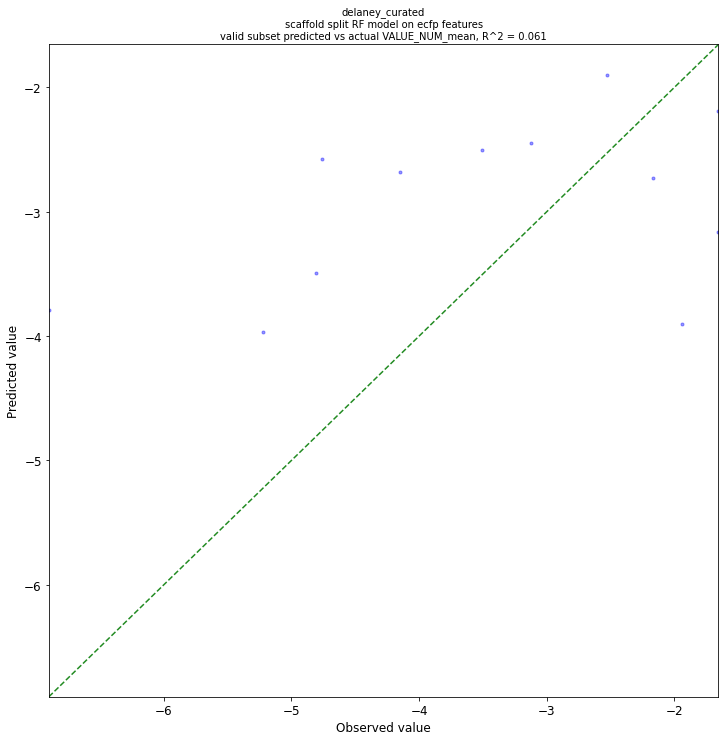

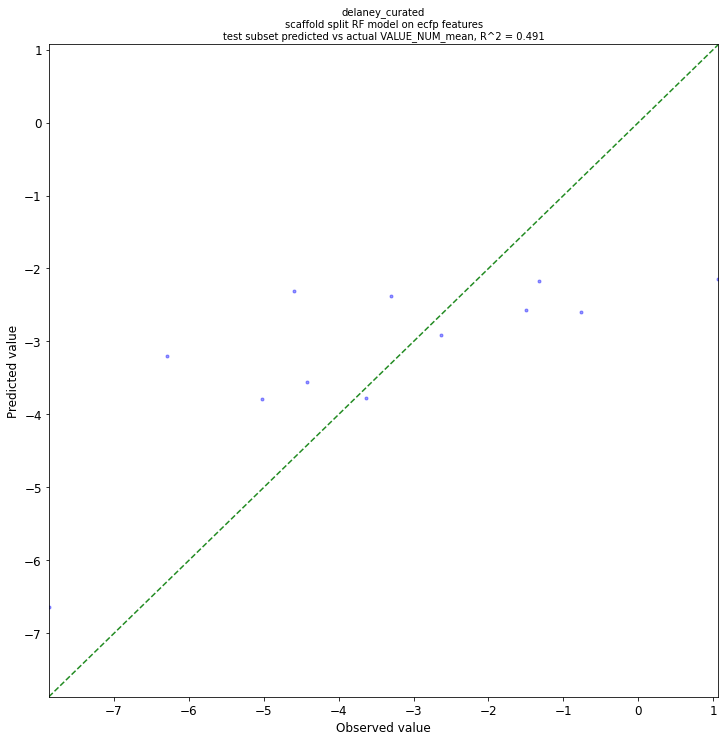

In [18]:
pparams = parse.wrapper(params)
MP = mp.ModelPipeline(pparams)
MP.train_model()
pp.plot_pred_vs_actual(MP)

In [19]:
pparams
# MP.train_model()

Namespace(autoencoder_bucket=None, autoencoder_key=None, autoencoder_type='molvae', base_splitter='scaffold', baseline_epoch=30, batch_size=50, bias_init_consts=None, bucket='public', butina_cutoff=0.18, class_name=None, class_number=2, collection_name='model_tracker', config_file=None, cutoff_date=None, data_owner='gsk', data_owner_group='gsk_craa', dataset_key='/content/delaney_curated.csv', dataset_name='delaney_curated', dataset_oid=None, datastore=False, date_col=None, descriptor_bucket='public', descriptor_key=None, descriptor_oid=None, descriptor_spec_bucket='', descriptor_spec_key='/usr/local/lib/python3.7/site-packages/atomsci/ddm/data/descriptor_sets_sources_by_descr_type.csv', descriptor_type='moe', dp=None, dropout_list=None, dropouts=None, ecfp_radius=2, ecfp_size=1024, feature_transform_type='normalization', featurizer='ecfp', hyperparam=False, hyperparam_uuid=None, id_col='compound_id', layer_nums=None, layer_sizes=None, lc_account='baasic', learning_rate=0.0005, lr=None

In [20]:
!date

Wed Mar 10 20:19:30 UTC 2021
